# Fine-tuning SpeechT5 for multilingual TTS

This notebook demonstrates how to fine-tune the SpeechT5 model from 🤗 Transformers on the **text-to-speech** task.

The unique thing about SpeechT5 is that the model is first pre-trained on a combination of speech-to-text and text-to-speech data, so that it learns a unified space of hidden representations shared by both text and speech. This allows us to fine-tune the same pretrained model on different tasks. Read more about SpeechT5 [in our blog post](https://huggingface.co/blog/speecht5).

In this notebook we will start from an existing fine-tuned TTS model that was originally trained on English speech from LibriTTS, and fine-tune it for the Urdu Language.

This TTS model will support multiple speakers through x-vector speaker embeddings.

## Install required packages

We install Transformers from GitHub since not all the SpeechT5 features we need have been merged into an official release yet.


In [ ]:
!pip install datasets soundfile speechbrain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.1/760.1 kB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (41

In [ ]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-m7fgjodb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-m7fgjodb
  Resolved https://github.com/huggingface/transformers.git to commit 96a074fa7e2c04b904f72d9e827398d4c5f90f25
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.43.0.dev0-py3-none-any.whl size=9403605 sha256=c2505d30926e465339b5e53f7c1b7963724dddf757ce1523549bfbc390ce681b
  Stored in directory: /tmp/pip-ephem-wheel-cache-b7r1edg2/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [ ]:
!pip install --upgrade accelerate

Do we have a GPU?

In [ ]:
!nvidia-smi

Mon Jul 22 19:12:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In case no GPU is found, from the menu choose **Runtime > Change runtime type** and set **Hardware accelerator** to **GPU**. Then restart the runtime to activate the GPU.

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again but for a new language. For more info about the original checkpoint, you can find its model card on the [Hugging Face Hub](https://huggingface.co/microsoft/speecht5_tts).

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

## Load the dataset

We'll fine-tune on the Urdu language.

You can find [common_voice_urdu1 on the Hugging Face Hub](https://huggingface.co/datasets/m-aliabbas/common_voice_urdu1).


In [ ]:
from datasets import load_dataset, Audio

dataset = load_dataset(
    "m-aliabbas/common_voice_urdu1",split="train"
)

Generating train split:   0%|          | 0/4112 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [ ]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

Let's quickly check how many examples are in this dataset.

In [ ]:
len(dataset)

4112

That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [ ]:
tokenizer = processor.tokenizer

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

In [ ]:
def urdu_to_roman_urdu(text):
    urdu_to_roman_dict = {
        'ا': 'a', 'ب': 'b', 'پ': 'p', 'ت': 't', 'ٹ': 't', 'ث': 's', 'ج': 'j', 'چ': 'ch',
        'ح': 'h', 'خ': 'kh', 'د': 'd', 'ڈ': 'd', 'ذ': 'z', 'ر': 'r', 'ڑ': 'r', 'ز': 'z',
        'ژ': 'zh', 'س': 's', 'ش': 'sh', 'ص': 's', 'ض': 'z', 'ط': 't', 'ظ': 'z', 'ع': 'a',
        'غ': 'gh', 'ف': 'f', 'ق': 'q', 'ک': 'k', 'گ': 'g', 'ل': 'l', 'م': 'm', 'ن': 'n',
        'ں': 'n', 'و': 'w', 'ہ': 'h', 'ء': 'a', 'ی': 'y', 'ے': 'e', 'آ': 'a', 'ؤ': 'o',
        'ئ': 'y', 'ٔ': '', ' ': ' ', '۔': '.', '،': ',', '؛': ';', '؟': '?','ھ': 'h'
    }

    roman_text = ''.join(urdu_to_roman_dict.get(char, char) for char in text)
    return roman_text

def cleanup_text(inputs):
    inputs["transcription"] = urdu_to_roman_urdu(inputs["transcription"])
    return inputs

dataset = dataset.map(cleanup_text)

Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [ ]:
import speechbrain
print(speechbrain.__version__)



1.0.0


In [ ]:
!pip install git+https://github.com/speechbrain/speechbrain.git@develop


  Cloning https://github.com/speechbrain/speechbrain.git (to revision develop) to /tmp/pip-req-build-37q6gxx1
  Running command git clone --filter=blob:none --quiet https://github.com/speechbrain/speechbrain.git /tmp/pip-req-build-37q6gxx1
  Resolved https://github.com/speechbrain/speechbrain.git to commit 46e282f46e3047fca30fc914d0cb39ab2684238d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import torch
from speechbrain.inference.speaker import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["transcription"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [ ]:
processed_example = prepare_dataset(dataset[0])

This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [ ]:
tokenizer.decode(processed_example["input_ids"])

'kash yh wqt kbhy nh gzre.</s>'

Speaker embeddings should be a 512-element vector:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

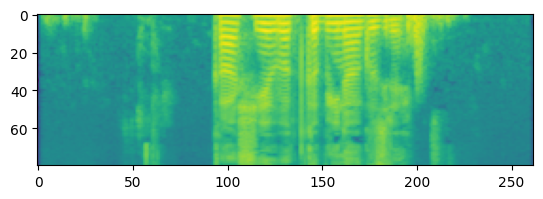

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()


If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset. This can take between 5 and 10 minutes.

In [ ]:
dataset = dataset.map(
    prepare_dataset, remove_columns=dataset.column_names,
)

Map:   0%|          | 0/4112 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (9497 > 600). Running this sequence through the model will result in indexing errors


Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/4112 [00:00<?, ? examples/s]

How many examples are left?

In [ ]:
len(dataset)

4111

## Train/test split

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [ ]:
dataset = dataset.train_test_split(test_size=0.1)

What does the dataset look like now?

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 3699
    })
    test: Dataset({
        features: ['input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 412
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 106]),
 'attention_mask': torch.Size([3, 106]),
 'labels': torch.Size([3, 580, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [ ]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_urdu",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=1e-5,
    warmup_steps=300,
    max_steps=10500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Create the trainer object using the model, dataset, and data collator.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

max_steps is given, it will override any value given in num_train_epochs


And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/utils/che

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.
/usr/local/lib/python3.10/dist-packages/torch/utils/che

TrainOutput(global_step=10500, training_loss=0.4873873142969041, metrics={'train_runtime': 11266.2505, 'train_samples_per_second': 29.824, 'train_steps_per_second': 0.932, 'total_flos': 2.251261023307164e+16, 'train_loss': 0.4873873142969041, 'epoch': 90.51724137931035})

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "m-aliabbas/common_voice_urdu1",
    "dataset": "common_voice_urdu1",  # a 'pretty' name for the training dataset
    "dataset_args": "split: train",
    "model_name": "SpeechT5 TTS urdu",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
}


The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [ ]:
trainer.push_to_hub(**kwargs)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be raised to an exception in v4.41.


events.out.tfevents.1721676197.d34fde1d2e44.268.2:   0%|          | 0.00/101k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/pocketmonkey/speecht5_tts_urdu/commit/9be7dcf5e5852928f45804bd67da59f3a93d610f', commit_message='End of training', commit_description='', oid='9be7dcf5e5852928f45804bd67da59f3a93d610f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.save_pretrained("")
tokenizer.save_pretrained("your_model_save_directory")

FileNotFoundError: [Errno 2] No such file or directory: ''

You can now share this model with anyone using the link on the Hub.

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [ ]:
model= SpeechT5ForTextToSpeech.from_pretrained("pocketmonkey/speecht5_tts_urdu")

config.json:   0%|          | 0.00/2.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [ ]:
example = dataset["test"][304]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [ ]:
text = "زندگی میں کامیابی"

In [ ]:
def urdu_to_roman_urdu(text):
    urdu_to_roman_dict = {
        'ا': 'a', 'ب': 'b', 'پ': 'p', 'ت': 't', 'ٹ': 't', 'ث': 's', 'ج': 'j', 'چ': 'ch',
        'ح': 'h', 'خ': 'kh', 'د': 'd', 'ڈ': 'd', 'ذ': 'z', 'ر': 'r', 'ڑ': 'r', 'ز': 'z',
        'ژ': 'zh', 'س': 's', 'ش': 'sh', 'ص': 's', 'ض': 'z', 'ط': 't', 'ظ': 'z', 'ع': 'a',
        'غ': 'gh', 'ف': 'f', 'ق': 'q', 'ک': 'k', 'گ': 'g', 'ل': 'l', 'م': 'm', 'ن': 'n',
        'ں': 'n', 'و': 'w', 'ہ': 'h', 'ء': 'a', 'ی': 'y', 'ے': 'e', 'آ': 'a', 'ؤ': 'o',
        'ئ': 'y', 'ٔ': '', ' ': ' ', '۔': '.', '،': ',', '؛': ';', '؟': '?','ھ': 'h'
    }

    roman_text = ''.join(urdu_to_roman_dict.get(char, char) for char in text)
    return roman_text


In [ ]:
text=urdu_to_roman_urdu(text)

In [ ]:
text

'zndgy myn kamyaby'

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

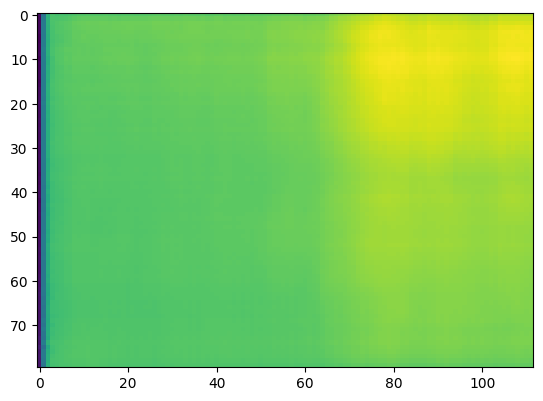

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.